In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import graph_tool.all as gt

from pyvis.network import Network
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import display
from IPython.display import IFrame

from utils.measure import *

sns.set_context("talk")

### 1. Data Preparation

In [2]:
from scipy.io import loadmat

In [3]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/df_cleaned.csv"
potential_connmat = pd.read_csv(data_path) 

In [4]:
potential_connmat

,psd_segid,BBOX_bx,BBOX_by,BBOX_bz,BBOX_ex,BBOX_ey,BBOX_ez,postsyn_sz,postsyn_wt,postsyn_x,...,presyn_wt,presyn_x,presyn_y,presyn_z,size,postsyn_segid,presyn_segid,centroid_x,centroid_y,centroid_z
0,2,15037,20682,16656,15049,20719,16657,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,271,NaN,NaN,15043.0,20700.0,16656.0
1,3,15261,20788,16418,15290,20836,16419,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,253,NaN,NaN,15271.0,20811.0,16418.0
2,4,15358,20534,16389,15345,20527,16389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,259,NaN,NaN,15360.0,20533.0,16390.0
3,6,14673,22039,16487,14678,22100,16488,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,240,NaN,NaN,14675.0,22070.0,16487.0
4,7,15346,22283,16492,15325,22272,16491,25234.0,0.727412,15359.0,...,0.569262,15315.0,22298.0,16500.0,944,266713.0,266721.0,15360.0,22276.0,16492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029004,2720208,83783,43612,17610,83794,43645,17611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,269,NaN,NaN,83787.0,43628.0,17610.0
2029005,2720210,83065,44257,17610,83109,44269,17611,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,329,NaN,NaN,83087.0,44262.0,17610.0
2029006,2720211,83279,44046,17563,83385,44096,17566,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1800,NaN,NaN,83343.0,44073.0,17564.0
2029007,2720212,83428,44518,17630,83484,44532,17631,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,315,NaN,NaN,83458.0,44524.0,17630.0


In [5]:
modO = gt.load_graph("saved/gt-ax50-dd100-modO-sg.xml.gz")

In [7]:
modO

<Graph object, directed, with 223 vertices and 2725 edges, 22 internal vertex properties, 2 internal edge properties, at 0x7f1a74717278>

In [6]:
np.unique(modO.vp["modO_sg_3sbm"].a, return_counts=True)

(PropertyArray([0, 1, 2], dtype=int32), array([80, 70, 73]))

### 2. Compute Potential Synapses

In [8]:
modO_cells =  [modO.vp["cellid"][v] for v in modO.vertices()]
modO_resyn = potential_connmat[potential_connmat["presyn_segid"].isin(modO_cells) 
                 & potential_connmat["postsyn_segid"].isin(modO_cells)][["presyn_segid", "postsyn_segid",
                                                                         "presyn_x", "presyn_y", "presyn_z",
                                                                        "postsyn_x", "postsyn_y", "postsyn_z"]]

In [13]:
len(np.unique(modO_resyn[["presyn_segid", "postsyn_segid"]], axis=0))

2729

In [14]:
resolution = np.array([0.005,0.005,0.045])

In [15]:
modO_resyn["dist"] = np.sqrt((((np.array(modO_resyn[["presyn_x", "presyn_y", "presyn_z"]]) -\
    np.array(modO_resyn[["postsyn_x", "postsyn_y", "postsyn_z"]])) * resolution)**2).sum(1))

In [359]:
len(modO_resyn["dist"])

4674

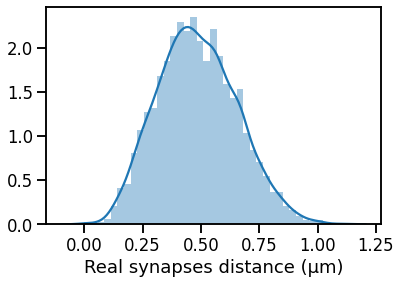

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.distplot(modO_resyn["dist"])
ax.set_xlabel("Real synapses distance (μm)")
plt.show()

In [27]:
modO_pre_sites = potential_connmat[potential_connmat["presyn_segid"].isin(modO_cells)][
                    ["presyn_segid", "presyn_x", "presyn_y", "presyn_z"]]

In [29]:
modO_post_sites = potential_connmat[potential_connmat["postsyn_segid"].isin(modO_cells)][
                    ["postsyn_segid", "postsyn_x", "postsyn_y", "postsyn_z"]]

In [56]:
def get_pt_syn(modO_pre_sites, modO_post_sites, th=5):
    modO_pt_syn = {}
    for i, axon_site in modO_pre_sites.iterrows():
        dist = np.sqrt((((np.array(modO_post_sites[["postsyn_x", "postsyn_y", "postsyn_z"]]) - \
                 np.array(axon_site[["presyn_x", "presyn_y", "presyn_z"]])) * resolution) ** 2).sum(1))
        dist <= th
        for post_id in modO_post_sites["postsyn_segid"][dist <= th]:
            if (int(axon_site["presyn_segid"]), int(post_id)) in modO_pt_syn.keys():
                modO_pt_syn[(int(axon_site["presyn_segid"]), int(post_id))] += 1
            else:
                modO_pt_syn[(int(axon_site["presyn_segid"]), int(post_id))] = 1
    return modO_pt_syn

In [57]:
modO_pt_syn_th5 = get_pt_syn(modO_pre_sites, modO_post_sites, th=5)

In [65]:
import pickle
with open("saved/mod_potential_syn_5um.pkl", 'wb') as f:
    pickle.dump(modO_pt_syn_th5, f)

In [67]:
modO_pt_syn_th2 = get_pt_syn(modO_pre_sites, modO_post_sites, th=2)
with open("saved/mod_potential_syn_2um.pkl", 'wb') as f:
    pickle.dump(modO_pt_syn_th2, f)

In [69]:
modO_pt_syn_th10 = get_pt_syn(modO_pre_sites, modO_post_sites, th=10)
with open("saved/mod_potential_syn_10um.pkl", 'wb') as f:
    pickle.dump(modO_pt_syn_th10, f)

### 3. Get Block Structure

In [71]:
g = gt.load_graph("saved/whole-label-ax50-dd100.xml.gz")

In [72]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_3sbm"].a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["modO_sg"][v] == True:
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["modO_sg_3sbm"] = vw

In [73]:
def validate_syn_prob_MI(g, sbm_name, weight='#synapses', norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 14))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)

    # merge scc-0 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 0)]
    center_fv0 = mclass[0]
    # print("center-0", center_fv0)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv0:
            merge_g.merge_vertices(v, center_fv0)

    # merge scc-1 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 1)]
    center_fv1 = mclass[0]
    # print("center-1", center_fv1)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv1:
            merge_g.merge_vertices(v, center_fv1)
            
    # merge scc-2 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 2)]
    center_fv2 = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv2:
            merge_g.merge_vertices(v, center_fv2)

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[[abdm_fv,abdm_fv,abdm_fv,abdi_fv,abdi_fv,abdi_fv],
                        [center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2]].reshape(2,3)
    
    syn_prob_block = A_mg[[center_fv0,center_fv0,center_fv0,center_fv1,center_fv1,center_fv1,center_fv2,center_fv2,center_fv2],
                        [center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2]
                         ].reshape(3,3)

    return syn_prob_abd, syn_prob_block

In [74]:
gen_mask = lambda x: np.array(x, dtype="bool")

In [75]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_{}_3sbm".format(k),  weight='#synapses', norm=True)

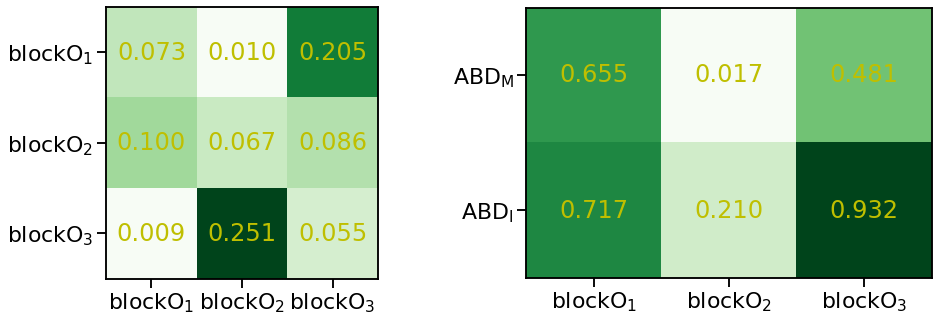

In [140]:
fig, axs = plt.subplots(1,2, figsize=(16,5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y", fontsize=24)
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y", fontsize=24)
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"], fontsize=22)

plt.savefig("figures/paper/blockO123-output.pdf",bbox_inches="tight")

In [77]:
syn_prob_block['sg']

matrix([[0.07328125, 0.00982143, 0.20462329],
        [0.09964286, 0.06673469, 0.08551859],
        [0.00907534, 0.25068493, 0.05516983]])

In [81]:
cell2modO = {}
for i, cid in enumerate(modO.vp['cellid'].a):
    cell2modO[cid] = modO.vp['modO_sg_3sbm'].a[i]

In [88]:
mod_size = {}
modid, cell_cnt = np.unique(modO.vp['modO_sg_3sbm'].a, return_counts=True)
for i in modid:
    mod_size[i] = cell_cnt[i]

In [89]:
mod_size

{0: 80, 1: 70, 2: 73}

In [112]:
def get_block_matrix(modO_pt_syn_thx):
    syn_prob_pt = np.zeros((3,3))
    for pre, post in modO_pt_syn_thx.keys():
        post_mod = cell2modO[post]
        pre_mod = cell2modO[pre]
        syn_prob_pt[post_mod, pre_mod] += modO_pt_syn_thx[(pre, post)] / (mod_size[pre_mod] 
                                                                              * mod_size[post_mod])
    return syn_prob_pt

In [113]:
syn_prob_pt_th2 = get_block_matrix(modO_pt_syn_th2)

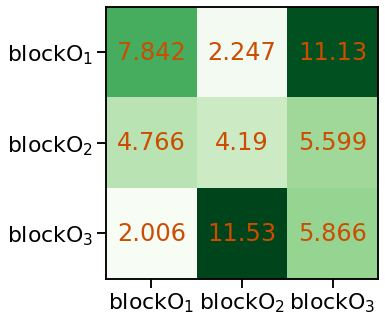

In [142]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(syn_prob_pt_th2, cmap="Greens")
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, "{:.4}".format(syn_prob_pt_th2[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(3))
ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
ax.set_yticks(range(3))
ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

In [120]:
syn_prob_pt_th5 = get_block_matrix(modO_pt_syn_th5)

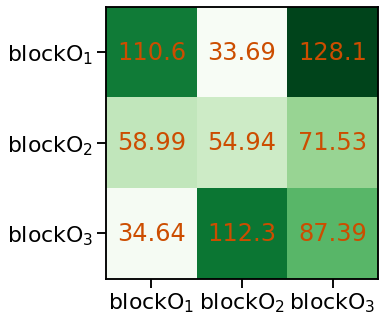

In [145]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.imshow(syn_prob_pt_th5, cmap="Greens")
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, "{:.4}".format(syn_prob_pt_th5[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(3))
ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
ax.set_yticks(range(3))
ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
plt.savefig("figures/paper/peter-blockO123-5um.pdf",bbox_inches="tight")

In [130]:
syn_prob_pt_th10 = get_block_matrix(modO_pt_syn_th10)

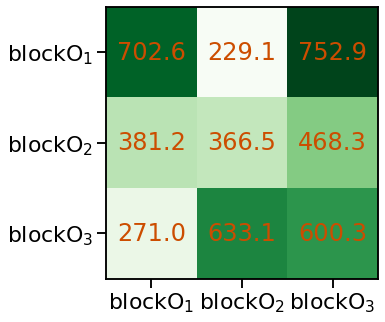

In [146]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.imshow(syn_prob_pt_th10, cmap="Greens")
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, "{:.4}".format(syn_prob_pt_th10[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(3))
ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
ax.set_yticks(range(3))
ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"], fontsize=22)
plt.savefig("figures/paper/peter-blockO123-10um.pdf",bbox_inches="tight")

### 4. Compute Potential Synapses in the Center Subgraph

In [149]:
g = gt.load_graph("saved/whole-w-all-abd.xml.gz")

In [358]:
len(center_pt_syn_th2)

41937

In [152]:
center_cells = [g.vp["cellid"][v] for v in g.vertices() if g.vp["center"][v]]

In [154]:
resolution = np.array([0.005,0.005,0.045])

In [155]:
center_pre_sites = potential_connmat[potential_connmat["presyn_segid"].isin(center_cells)][
                    ["presyn_segid", "presyn_x", "presyn_y", "presyn_z"]]

In [156]:
center_post_sites = potential_connmat[potential_connmat["postsyn_segid"].isin(center_cells)][
                    ["postsyn_segid", "postsyn_x", "postsyn_y", "postsyn_z"]]

In [196]:
rs_cells = [g.vp["cellid"][v] for v in g.vertices() if g.vp["large_rs"][v]]

In [197]:
abd_cells = [g.vp["cellid"][v] for v in g.vertices() if g.vp["celltype"][v] in [14,15]]

In [199]:
abd_rs_cells = abd_cells + rs_cells

In [200]:
abd_rs_post_sites = potential_connmat[potential_connmat["postsyn_segid"].isin(abd_rs_cells)][
                    ["postsyn_segid", "postsyn_x", "postsyn_y", "postsyn_z"]]

In [157]:
center_pt_syn_th5 = get_pt_syn(center_pre_sites, center_post_sites, th=5)

In [158]:
import pickle
with open("saved/center_potential_syn_5um.pkl", 'wb') as f:
    pickle.dump(center_pt_syn_th5, f)

In [159]:
center_pt_syn_th2 = get_pt_syn(center_pre_sites, center_post_sites, th=2)
with open("saved/center_potential_syn_2um.pkl", 'wb') as f:
    pickle.dump(center_pt_syn_th2, f)

In [160]:
center_pt_syn_th10 = get_pt_syn(center_pre_sites, center_post_sites, th=10)
with open("saved/center_potential_syn_10um.pkl", 'wb') as f:
    pickle.dump(center_pt_syn_th10, f)

In [201]:
abd_rs_pt_syn_th5 = get_pt_syn(center_pre_sites, abd_rs_post_sites, th=5)

In [202]:
import pickle
with open("saved/abd_rs_potential_syn_5um.pkl", 'wb') as f:
    pickle.dump(abd_rs_pt_syn_th5, f)

In [203]:
abd_rs_pt_syn_th2 = get_pt_syn(center_pre_sites, abd_rs_post_sites, th=2)
with open("saved/abd_rs_potential_syn_2um.pkl", 'wb') as f:
    pickle.dump(abd_rs_pt_syn_th2, f)

In [204]:
abd_rs_pt_syn_th10 = get_pt_syn(center_pre_sites, abd_rs_post_sites, th=10)
with open("saved/abd_rs_potential_syn_10um.pkl", 'wb') as f:
    pickle.dump(abd_rs_pt_syn_th10, f)

In [161]:
cell2OA = {g.vp["cellid"][v]:g.vp["sbm_sg"][v] for v in g.vertices() if g.vp["center"][v]}

In [173]:
_, mod_size_OA = np.unique(list(cell2OA.values()), return_counts=True)

In [174]:
mod_size_OA

array([223, 196])

In [374]:
def get_block_matrix_OA(modO_pt_syn_thx):
    syn_prob_pt = np.zeros((2,2))
    for pre, post in modO_pt_syn_thx.keys():
        post_mod = cell2OA[post]
        pre_mod = cell2OA[pre]
        syn_prob_pt[post_mod, pre_mod] += modO_pt_syn_thx[(pre, post)] / (mod_size_OA[pre_mod] 
                                                                              * mod_size_OA[post_mod])
#         syn_prob_pt[post_mod, pre_mod] += modO_pt_syn_thx[(pre, post)]
    return syn_prob_pt

In [375]:
center_syn_prob_pt_th2 = get_block_matrix_OA(center_pt_syn_th2)

[Text(0, 0, '$modO$'), Text(0, 1, '$modA$')]

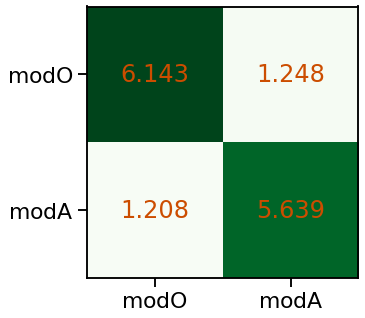

In [376]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(center_syn_prob_pt_th2, cmap="Greens")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.4}".format(center_syn_prob_pt_th2[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(2))
ax.set_xticklabels(["$modO$", "$modA$"], fontsize=22)
ax.set_yticks(range(2))
ax.set_yticklabels(["$modO$", "$modA$"], fontsize=22)
# plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

In [377]:
center_syn_prob_pt_th5 = get_block_matrix_OA(center_pt_syn_th5)

[Text(0, 0, '$modO$'), Text(0, 1, '$modA$')]

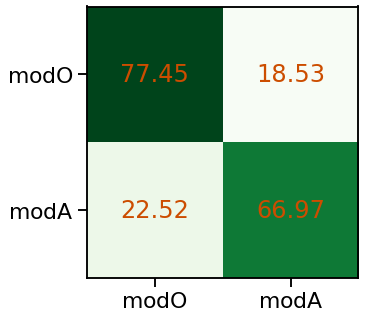

In [378]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(center_syn_prob_pt_th5, cmap="Greens")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.4}".format(center_syn_prob_pt_th5[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(2))
ax.set_xticklabels(["$modO$", "$modA$"], fontsize=22)
ax.set_yticks(range(2))
ax.set_yticklabels(["$modO$", "$modA$"], fontsize=22)
# plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

In [379]:
center_syn_prob_pt_th10 = get_block_matrix_OA(center_pt_syn_th10)

[Text(0, 0, '$modO$'), Text(0, 1, '$modA$')]

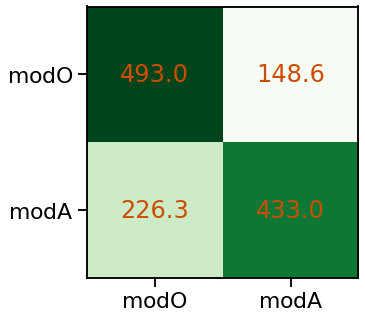

In [380]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(center_syn_prob_pt_th10, cmap="Greens")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.4}".format(center_syn_prob_pt_th10[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(2))
ax.set_xticklabels(["$modO$", "$modA$"], fontsize=22)
ax.set_yticks(range(2))
ax.set_yticklabels(["$modO$", "$modA$"], fontsize=22)
# plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

In [190]:
gen_mask = lambda x: np.array(x, dtype="bool")

In [191]:
def validate_syn_prob(g, sbm_name, weight='#synapses', norm=True, RS=False):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    if RS:
        mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['large_rs'].a == True))]
    else:
        mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a != 14) &
                                       (m.vp['celltype'].a != 15))]
    non_abd_fv = mclass[0]
    # print("sink-non-abd", non_abd_fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != non_abd_fv:
            merge_g.merge_vertices(v, non_abd_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                   ((m.vp['celltype'].a == 14) |
                                   (m.vp['celltype'].a == 15)))]
    abd_fv = mclass[0]
    # print("sink-abd", abd_fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abd_fv:
            merge_g.merge_vertices(v, abd_fv)

    # merge scc-0 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 0)]
    center_fv0 = mclass[0]
    # print("center-0", center_fv0)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv0:
            merge_g.merge_vertices(v, center_fv0)

    # merge scc-1 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 1)]
    center_fv1 = mclass[0]
    # print("center-1", center_fv1)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv1:
            merge_g.merge_vertices(v, center_fv1)

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[[abd_fv,abd_fv,non_abd_fv,non_abd_fv],
                        [center_fv0,center_fv1,center_fv0,center_fv1]].reshape(2,2)
    
    syn_prob_block = A_mg[[center_fv0,center_fv0,center_fv1,center_fv1],
                        [center_fv0,center_fv1,center_fv0,center_fv1]].reshape(2,2)

    return syn_prob_abd, syn_prob_block

In [192]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg_nd', 'mg_c', 'sg', 'wc_c', 'sc_c']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob(g, "sbm_{}".format(k),  weight='#synapses', norm=True, RS=True)

In [206]:
# abd_cells

In [207]:
cell2ABD_RS = {c:0 if c in abd_cells else 1 for c in abd_rs_cells}

In [208]:
_, mod_size_ABD_RS = np.unique(list(cell2ABD_RS.values()), return_counts=True)

In [209]:
mod_size_ABD_RS

array([54,  4])

In [210]:
def get_block_matrix_ABD_RS(modO_pt_syn_thx):
    syn_prob_pt = np.zeros((2,2))
    for pre, post in modO_pt_syn_thx.keys():
        post_mod = cell2ABD_RS[post]
        pre_mod = cell2OA[pre]
        syn_prob_pt[post_mod, pre_mod] += modO_pt_syn_thx[(pre, post)] / (mod_size_OA[pre_mod] 
                                                                              * mod_size_ABD_RS[post_mod])
    return syn_prob_pt

In [211]:
abd_rs_syn_prob_pt_th2 = get_block_matrix_ABD_RS(abd_rs_pt_syn_th2)

In [213]:
abd_rs_syn_prob_pt_th5 = get_block_matrix_ABD_RS(abd_rs_pt_syn_th5)
abd_rs_syn_prob_pt_th10 = get_block_matrix_ABD_RS(abd_rs_pt_syn_th10)

[Text(0, 0, '$ABD$'), Text(0, 1, '$RS$')]

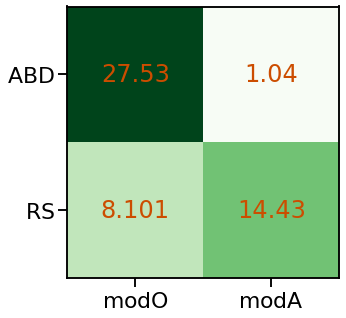

In [212]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(abd_rs_syn_prob_pt_th2, cmap="Greens")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.4}".format(abd_rs_syn_prob_pt_th2[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(2))
ax.set_xticklabels(["$modO$", "$modA$"], fontsize=22)
ax.set_yticks(range(2))
ax.set_yticklabels(["$ABD$", "$RS$"], fontsize=22)
# plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

[Text(0, 0, '$ABD$'), Text(0, 1, '$RS$')]

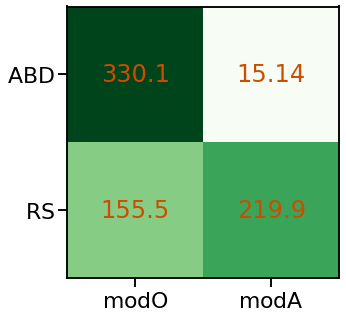

In [269]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(abd_rs_syn_prob_pt_th5, cmap="Greens")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.4}".format(abd_rs_syn_prob_pt_th5[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(2))
ax.set_xticklabels(["$modO$", "$modA$"], fontsize=22)
ax.set_yticks(range(2))
ax.set_yticklabels(["$ABD$", "$RS$"], fontsize=22)
# plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

[Text(0, 0, '$ABD$'), Text(0, 1, '$RS$')]

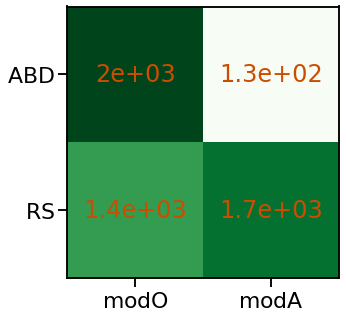

In [277]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.imshow(abd_rs_syn_prob_pt_th10, cmap="Greens")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, "{:.2}".format(abd_rs_syn_prob_pt_th10[i, j]),
                       ha="center", va="center", color=(0.8,0.3,0), fontsize=24)
ax.set_xticks(range(2))
ax.set_xticklabels(["$modO$", "$modA$"], fontsize=22)
ax.set_yticks(range(2))
ax.set_yticklabels(["$ABD$", "$RS$"], fontsize=22)
# plt.savefig("figures/paper/peter-blockO123-2um.pdf",bbox_inches="tight")

In [186]:
def iir(m):
    return (m[0,0] + m[1,1])/(m[1,0]+m[0,1])

In [221]:
def abd_s(m):
    return m[0,0]/m[0,1]

def rs_s(m):
    return m[1,1]/m[1,0]

def modO_s(m):
    return m[0,0]/m[1,0]

def modA_s(m):
    return m[1,1]/m[0,1]

In [382]:
[iir(m) for m in [syn_prob_block['sg'], center_syn_prob_pt_th2, 
                 center_syn_prob_pt_th5, center_syn_prob_pt_th10]]

[7.018421425891471, 4.797454055401937, 3.5183332518170785, 2.469615659502861]

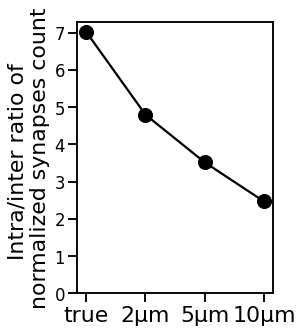

In [383]:
fig, ax = plt.subplots(1,1,figsize=(3.5,5))
ax.plot([iir(m) for m in [syn_prob_block['sg'], center_syn_prob_pt_th2, 
                 center_syn_prob_pt_th5, center_syn_prob_pt_th10]], color='k', marker='o',
                 markersize=14)
ax.set_xticks(range(4))
ax.set_xticklabels(["true","2μm","5μm","10μm"], fontsize=22)
ax.set_ylim([0,7.3])
ax.set_ylabel("Intra/inter ratio of \nnormalized synapses count", fontsize=22)
plt.savefig("figures/paper/peter-iir.pdf", bbox_inches="tight")

Text(0, 0.5, 'Intra/inter ratio of \n P(synapse | contact)')

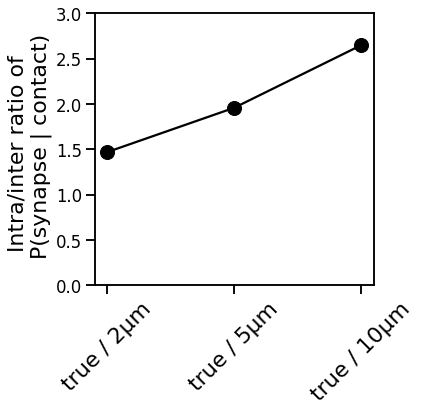

In [484]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot([iir(m) for m in [
                 syn_prob_block['sg']/center_syn_prob_pt_th2, 
                 syn_prob_block['sg']/center_syn_prob_pt_th5, 
                 syn_prob_block['sg']/center_syn_prob_pt_th10]], color='k', marker='o',
                 markersize=14)
ax.set_xticks(range(3))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_xticklabels(["true / 2μm","true / 5μm","true / 10μm"], fontsize=22)
ax.set_ylim([0,3])
ax.set_ylabel("Intra/inter ratio of \n P(synapse | contact)", fontsize=22)
# plt.savefig("figures/paper/peter-iir.pdf", bbox_inches="tight")

In [219]:
[abd_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]]

[29.092376681614347,
 26.460617768793163,
 21.798672633653265,
 15.291446727822596]

In [220]:
[rs_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]]

[3.6718460111317257,
 1.7812653569592782,
 1.4143755235069722,
 1.2277995347921653]

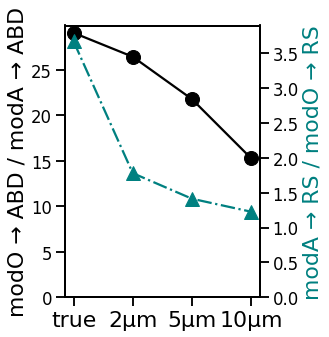

In [282]:
fig, ax = plt.subplots(1,1,figsize=(3.5,5))
ax.plot([abd_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]], color='k', marker='o',
                 markersize=14)
ax2 = ax.twinx()
ax2.plot([rs_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]], '-.', color='teal', marker='^',
                 markersize=14)
ax.set_xticks(range(4))
ax.set_ylim([0,29.9])
ax2.set_ylim([0,3.9])
ax.set_xticklabels(["true","2μm","5μm","10μm"], fontsize=22)
ax.set_ylabel("modO → ABD / modA → ABD", fontsize=22)
ax2.set_ylabel("modA → RS / modO → RS", fontsize=22, color='teal')
plt.savefig("figures/paper/peter-abd-rs.pdf", bbox_inches="tight")

In [222]:
[modO_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]]

[10.030303030303031,
 3.3984684934034153,
 2.1232746547706633,
 1.4199164051227082]

In [223]:
[modA_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]]

[10.649999999999999,
 13.869006538321731,
 14.520735199615794,
 13.222490500838502]

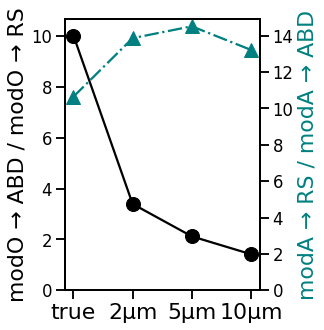

In [284]:
fig, ax = plt.subplots(1,1,figsize=(3.5,5))
ax.plot([modO_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]], color='k', marker='o',
                 markersize=14)
ax2 = ax.twinx()
ax2.plot([modA_s(m) for m in [syn_prob_abd['sg'], abd_rs_syn_prob_pt_th2, 
                 abd_rs_syn_prob_pt_th5, abd_rs_syn_prob_pt_th10]], '-.', color='teal', marker='^',
                 markersize=14)
ax.set_xticks(range(4))
ax.set_ylim([0,10.7])
ax2.set_ylim([0,14.95])
ax.set_xticklabels(["true","2μm","5μm","10μm"], fontsize=22)
ax.set_ylabel("modO → ABD / modO → RS", fontsize=22)
ax2.set_ylabel("modA → RS / modA → ABD", fontsize=22, color='teal')
plt.savefig("figures/paper/peter-O-A.pdf", bbox_inches="tight")

In [287]:
max(g.get_in_degrees(g.get_vertices()))

417

In [351]:
top1 = np.argsort(g.get_in_degrees(g.get_vertices(), eweight=g.ep["#synapses"]))[::-1][:20]

In [352]:
top2 = g.get_vertices()[np.argsort(g.get_in_degrees(g.get_vertices()))[::-1][:20]]

In [353]:
np.unique(g.vp["celltype"].a[top1], return_counts=True)

(PropertyArray([-1,  4, 14, 15], dtype=int32), array([ 3,  4,  3, 10]))

In [354]:
np.unique(g.vp["celltype"].a[top2], return_counts=True)

(PropertyArray([-1,  4, 14, 15], dtype=int32), array([ 2,  3,  3, 12]))

In [355]:
sum(g.vp["celltype"].a==14)

32

In [356]:
sum(g.vp["celltype"].a==15)

22

In [357]:
sum(g.vp["celltype"].a==5)

35

In [417]:
intra_con = np.random.poisson(lam=10, size=1000)
inter_con = np.random.poisson(lam=5, size=1000)

In [418]:
sum(intra_con) / sum(inter_con)

1.9801642957323182

In [465]:
intra_syn = np.array([np.random.binomial(n=con, p=0.1, size=1) for con in intra_con]).T[0]
inter_syn = np.array([np.random.binomial(n=con, p=0.1, size=1) for con in inter_con]).T[0]

In [466]:
sum(intra_syn) / sum(inter_syn)

2.0261569416498992

In [467]:
sum(intra_syn[intra_syn==1]) / sum(inter_syn[inter_syn==1])

1.228956228956229

In [468]:
sum(intra_syn[intra_syn>=2]) / sum(inter_syn[inter_syn>=2])

3.21

In [428]:
len(intra_syn[intra_syn==1])

373

In [429]:
2*np.exp(-5*0.1)

1.2130613194252668

In [430]:
a = 10
b = 5
p = 0.1
(1 - (1 + a*p) * np.exp(-a*p)) / (1 - (1 + b*p) * np.exp(-b*p))

2.9293721686476006

In [458]:
(a*p * np.exp(-a*p)) / (b*p * np.exp(-b*p))

1.2130613194252668

In [459]:
(a*p * (1-np.exp(-a*p))) / (b*p * (1-np.exp(-b*p)))

3.213061319425267